In [1]:
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, CenterCrop, Resize
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Subset
from torchsummary import summary

%autoreload 2
from networks import *
from utils import *
from losses import *
from landscape import *
from datasets import *
from train_utils import *

import json
import pathlib
import matplotlib.pyplot as plt

## Training Setup

In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=100
latent_size = 24                            
learning_rate=1e-3
batch_size=512                                        
device=set_device("cuda", 0)
valid_ratio = 0.2
logf = (nepochs//2) + 1


No GPU available! Running on CPU


/home/dp4018/miniconda3/envs/mltorch/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


## Datasets and Dataloaders

Training images: 162080 	 Validation Images: 40519


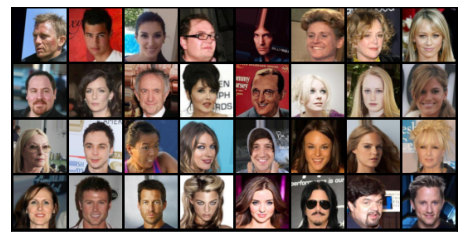

torch.Size([32, 3, 64, 64]) 0.0 1.0


In [3]:
# Datasets and dataloaders
img_dim = 64
ds = ImageFolder(root="/home/dp4018/scripts/AWLoss/examples/data/celeba/",
                               transform=Compose([
                               Resize(img_dim),
                               CenterCrop(img_dim),
                               ToTensor()]))

# Train / validation split
idxs = np.arange(0, len(ds), 1)
i = int(len(ds)*valid_ratio)
np.random.seed(42)
np.random.shuffle(idxs)
train_idxs, valid_idxs = idxs[:-i], idxs[-i:]
# train_idxs, valid_idxs = [i for i in range(0, 1)], [i for i in range(0, 64)]
trainds, validds = Subset(ds, train_idxs), Subset(ds, valid_idxs)
print("Training images: {} \t Validation Images: {}".format(len(trainds), len(validds)))

# Dataloaders
train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(validds, batch_size=1000, shuffle=False, num_workers=4)

# Visualise batch
sample_batch = next(iter(train_loader))[0][:32]
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(make_grid(sample_batch, pad_value=0, padding=3).numpy(),(1,2,0)))
plt.xticks([]); plt.yticks([])
plt.show()

print(sample_batch.shape, sample_batch.min().item(), sample_batch.max().item())

## Autoencoder (CNN)

In [4]:
def model_instance():
    model = CelebConvAE(latent_size=latent_size, 
                        n_channels=sample_batch.shape[1],
                        pre_latent_size=int(img_dim/2)).to(device)
    model = nn.DataParallel(model, device_ids=[0, 1, 2, 3, 4, 5, 6, 7])
    return model

model_sample = model_instance()
_ = summary(model=model_sample, input_data=sample_batch[0].shape, verbose=1, depth=3, 
            col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
├─CelebConvAE: 1-1                       [-1, 3, 64, 64]           [-1, 3, 64, 64]           --
|    └─Sequential: 2-1                   [-1, 3, 64, 64]           [-1, 24]                  --
|    |    └─Block: 3-1                   [-1, 3, 64, 64]           [-1, 16, 64, 64]          480
|    |    └─Block: 3-2                   [-1, 16, 64, 64]          [-1, 32, 64, 64]          4,704
|    |    └─MaxPool2d: 3-3               [-1, 32, 64, 64]          [-1, 32, 32, 32]          --
|    |    └─Block: 3-4                   [-1, 32, 32, 32]          [-1, 64, 32, 32]          18,624
|    |    └─Flatten: 3-5                 [-1, 64, 32, 32]          [-1, 65536]               --
|    |    └─Linear: 3-6                  [-1, 65536]               [-1, 24]                  1,572,888
|    └─Sequential: 2-2                   [-1, 24]                  [-1, 3, 64, 64]           --
|    |    └─Linear: 

## Training AWLoss

In [5]:
class JointLoss(AWLoss):
    def __init__(self,  wmse=1., **kwargs):
        super(JointLoss, self).__init__(**kwargs)
        self.mse = nn.MSELoss(reduction=self.reduction)
        self.wmse = wmse

    def forward(self, recon, target):
        awloss = super().forward(recon, target)
        if self.wmse > 0.:
            mseloss = self.wmse * self.mse(recon, target)
        else:
            mseloss = torch.tensor([0.], requires_grad=True).to(awloss.device)
        return  awloss + mseloss

joint_loss = JointLoss(filter_dim=3,  std=3e-8, epsilon=5., gamma=1e-4, eta=0., filter_scale=3, 
                    reduction="sum", method="fft", store_filters="norm", wmse=0.)     
                
model = model_instance()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
summary_app = {"latent_size":latent_size,
                "aw_filter_dim" : joint_loss.filter_dim,
                "aw_epsilon" :  joint_loss.epsilon,
                "aw_gamma" :  joint_loss.gamma,
                "aw_eta" :  joint_loss.eta,
                 "aw_std" : joint_loss.std,
                 "wmse" : joint_loss.wmse}

In [6]:
str(joint_loss)

'JointLoss(\n  (mse): MSELoss()\n)'

N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



Training started ...


[W Copy.cpp:244] Warning: Casting complex values to real discards the imaginary part (function operator())



 {'epoch': 0, 'train_loss': 250.8163299560547, 'valid_loss': 481.33660888671875}
Filters range: [-0.12 , 0.32]


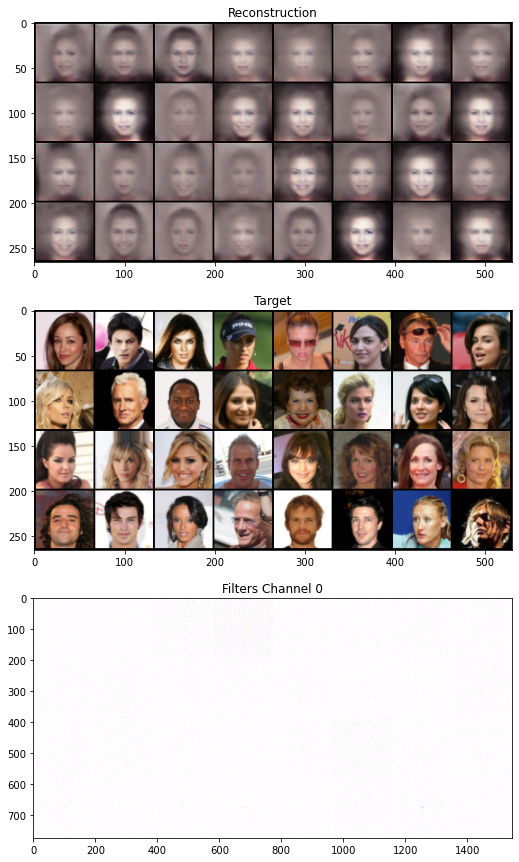

<Figure size 432x432 with 0 Axes>

Saving experiment at /home/dp4018/scripts/AWLoss/examples/celeba/exps/exp17 ...
	 exps/exp17/train_loader.pkl
	 exps/exp17/valid_loader.pkl
	 exps/exp17/sample_batch.pkl
	 exps/exp17/recon.pkl
	 exps/exp17/model.pkl
	 exps/exp17/optim.pkl
	 exps/exp17/loss.pkl
	 exps/exp17/train_losses.pkl
	 exps/exp17/vald_losses.pkl
	 exps/exp17/losses.png


  1% (1 of 100) |                        | Elapsed Time: 0:02:35 ETA:   4:16:28

	 exps/exp17/samples.png
	 summary.json


 51% (51 of 100) |###########            | Elapsed Time: 2:00:18 ETA:   1:55:19


 {'epoch': 51, 'train_loss': 245.03463745117188, 'valid_loss': 475.9754333496094}
Filters range: [-0.11 , 0.40]


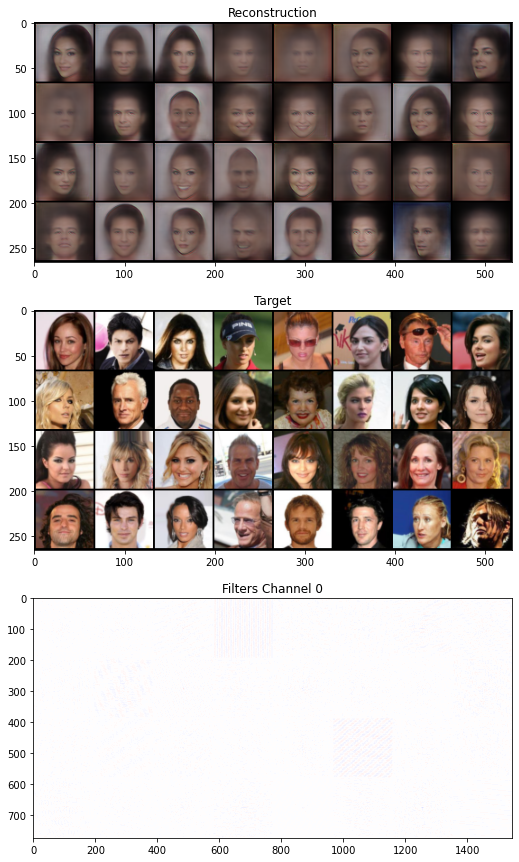

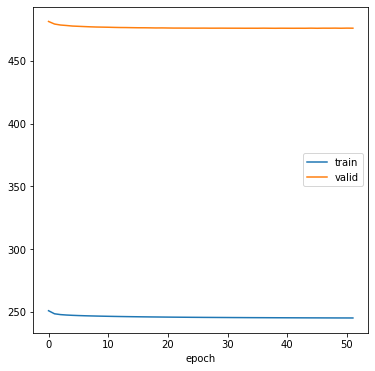

Saving experiment at /home/dp4018/scripts/AWLoss/examples/celeba/exps/exp17 ...
	 exps/exp17/train_loader.pkl
	 exps/exp17/valid_loader.pkl
	 exps/exp17/sample_batch.pkl
	 exps/exp17/recon.pkl
	 exps/exp17/model.pkl
	 exps/exp17/optim.pkl
	 exps/exp17/loss.pkl
	 exps/exp17/train_losses.pkl
	 exps/exp17/vald_losses.pkl
	 exps/exp17/losses.png


 52% (52 of 100) |###########            | Elapsed Time: 2:02:44 ETA:   1:56:37

	 exps/exp17/samples.png
	 summary.json


 99% (99 of 100) |###################### | Elapsed Time: 3:53:53 ETA:   0:02:24


 {'epoch': 99, 'train_loss': 244.69378662109375, 'valid_loss': 476.2470397949219}
Filters range: [-0.11 , 0.40]


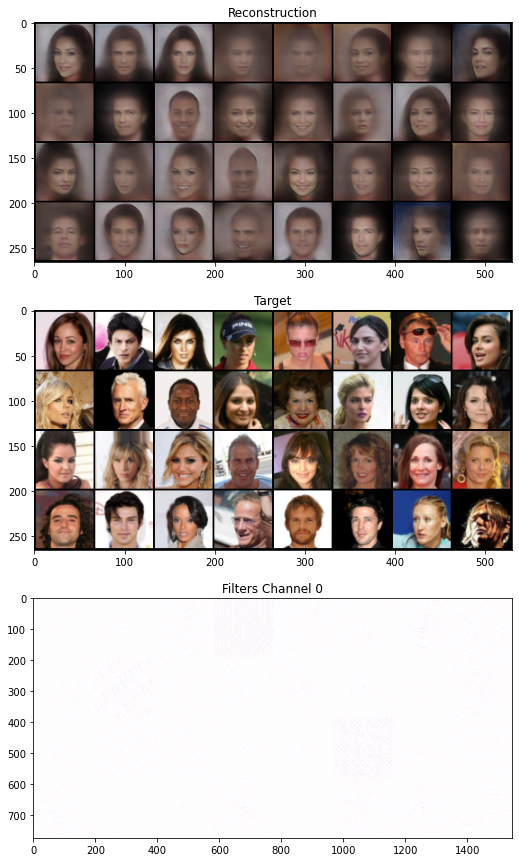

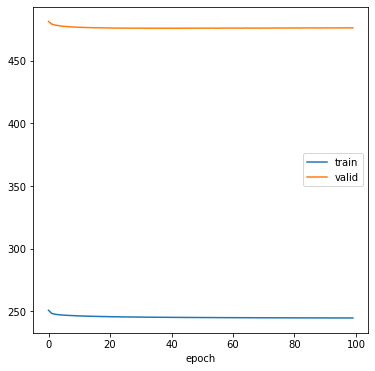

Saving experiment at /home/dp4018/scripts/AWLoss/examples/celeba/exps/exp17 ...
	 exps/exp17/train_loader.pkl
	 exps/exp17/valid_loader.pkl
	 exps/exp17/sample_batch.pkl
	 exps/exp17/recon.pkl
	 exps/exp17/model.pkl
	 exps/exp17/optim.pkl
	 exps/exp17/loss.pkl
	 exps/exp17/train_losses.pkl
	 exps/exp17/vald_losses.pkl
	 exps/exp17/losses.png


100% (100 of 100) |######################| Elapsed Time: 3:56:20 Time:  3:56:20


	 exps/exp17/samples.png
	 summary.json


In [11]:
train_model(model, optimizer, train_loader, valid_loader, joint_loss, nepochs=nepochs,
            log_frequency=logf, device=model.device_ids[0], gradflow=False, save=True,
            fcmap="seismic", summary_app=summary_app)
            



Training started ...


N/A% (0 of 150) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_loss': 369292.15625, 'valid_loss': 198853.203125}


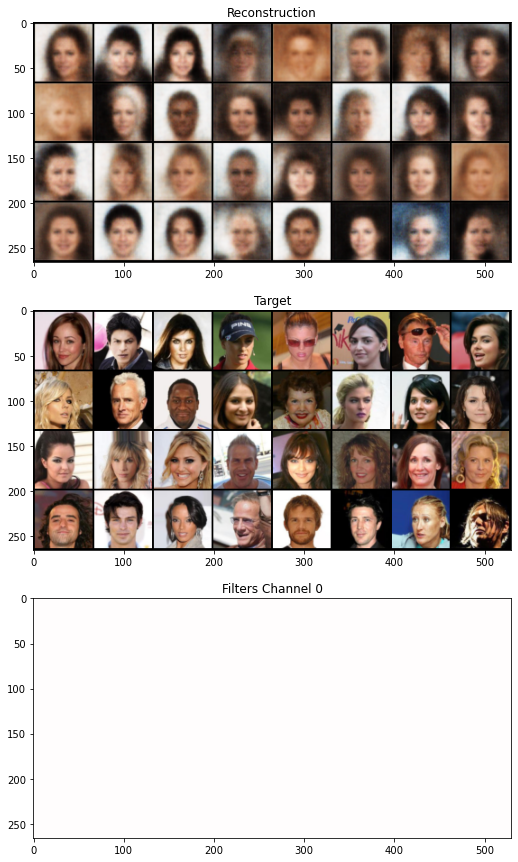

<Figure size 432x432 with 0 Axes>

Saving experiment at /home/dp4018/scripts/AWLoss/examples/celeba/exps/exp6 ...
	 exps/exp6/train_loader.pkl
	 exps/exp6/valid_loader.pkl
	 exps/exp6/sample_batch.pkl
	 exps/exp6/recon.pkl
	 exps/exp6/model.pkl
	 exps/exp6/optim.pkl
	 exps/exp6/loss.pkl
	 exps/exp6/train_losses.pkl
	 exps/exp6/vald_losses.pkl
	 exps/exp6/losses.png
	 exps/exp6/samples.png
	 summary.json


 50% (76 of 150) |###########            | Elapsed Time: 1:05:09 ETA:   1:03:29


 {'epoch': 76, 'train_loss': 146283.703125, 'valid_loss': 148089.53125}


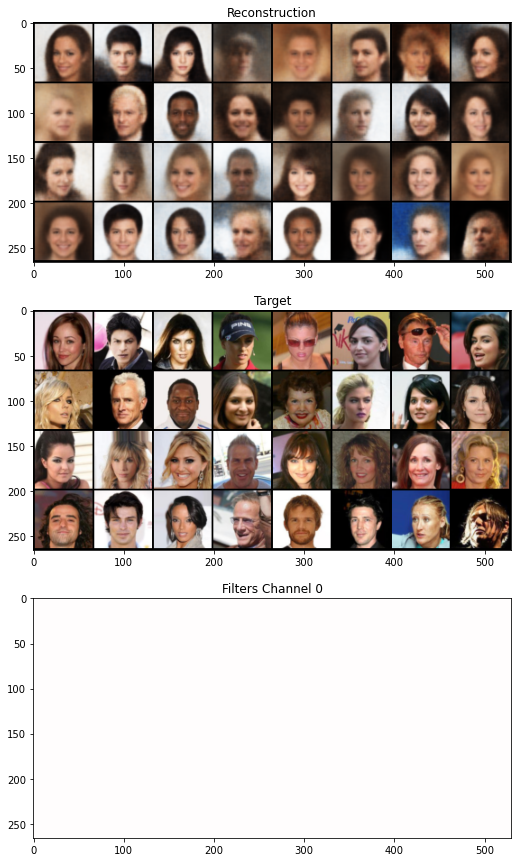

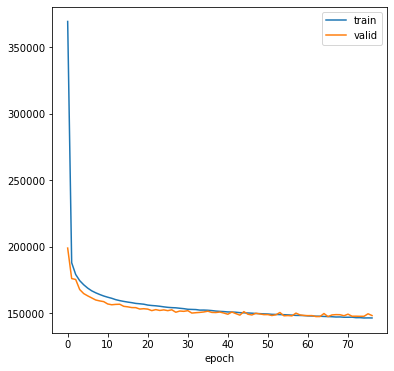

Saving experiment at /home/dp4018/scripts/AWLoss/examples/celeba/exps/exp6 ...
	 exps/exp6/train_loader.pkl
	 exps/exp6/valid_loader.pkl
	 exps/exp6/sample_batch.pkl
	 exps/exp6/recon.pkl
	 exps/exp6/model.pkl
	 exps/exp6/optim.pkl
	 exps/exp6/loss.pkl
	 exps/exp6/train_losses.pkl
	 exps/exp6/vald_losses.pkl
	 exps/exp6/losses.png
	 exps/exp6/samples.png
	 summary.json


 99% (149 of 150) |##################### | Elapsed Time: 2:07:26 ETA:   0:00:51


 {'epoch': 149, 'train_loss': 141858.625, 'valid_loss': 148558.640625}


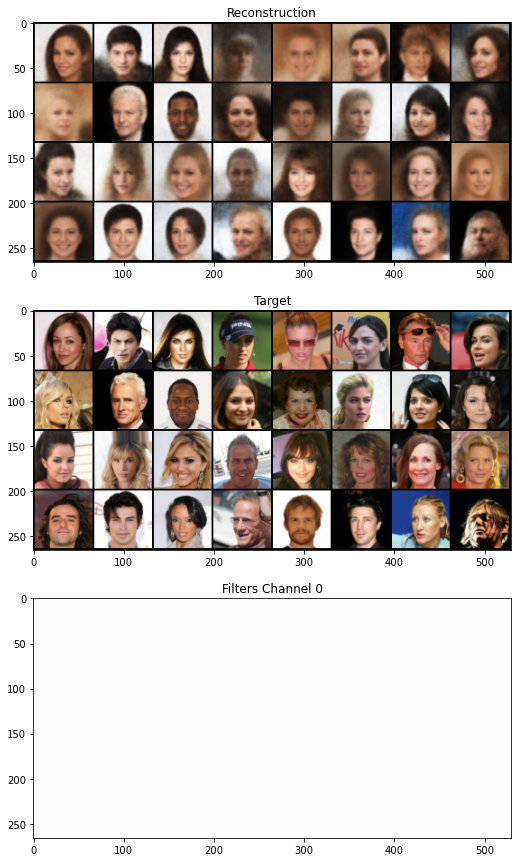

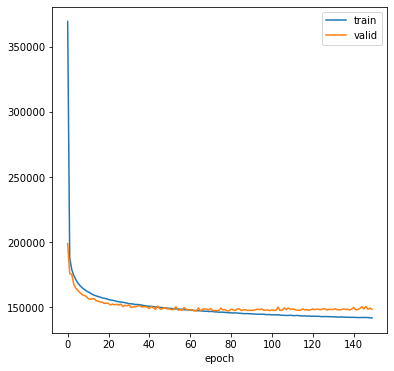

Saving experiment at /home/dp4018/scripts/AWLoss/examples/celeba/exps/exp6 ...
	 exps/exp6/train_loader.pkl
	 exps/exp6/valid_loader.pkl
	 exps/exp6/sample_batch.pkl
	 exps/exp6/recon.pkl
	 exps/exp6/model.pkl
	 exps/exp6/optim.pkl
	 exps/exp6/loss.pkl
	 exps/exp6/train_losses.pkl
	 exps/exp6/vald_losses.pkl
	 exps/exp6/losses.png


100% (150 of 150) |######################| Elapsed Time: 2:07:30 Time:  2:07:30


	 exps/exp6/samples.png
	 summary.json


In [6]:
l2loss    = nn.MSELoss(reduction="sum")

model = model_instance()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
summary_app = {"latent_size":latent_size}

train_model(model, optimizer, train_loader, valid_loader, l2loss, nepochs=nepochs,
            log_frequency=logf, device=model.device_ids[0], gradflow=False, save=True,
            fcmap="seismic", summary_app=summary_app)

In [2]:
def show_recon(exppath):
    exp = load_exp(exppath)
    model = exp["model"]
    valid_loader = exp["valid_loader"]
    recon = model(next(iter(valid_loader))[0])[:32]
    recon_scale = torch.empty_like(recon)
    for i in range(recon.shape[0]):
        for j in range(recon.shape[1]):
            recon_scale[i][j] = scale2range(recon[i][j], [0., 1.])
    fig = plt.figure(figsize=(10, 8))
    plt.imshow(make_grid(recon, pad_value=0, padding=2, vmin=0, vmax=1).cpu().data.permute(1, 2, 0))
    summ_path = pathlib.Path(exppath)/pathlib.Path("summary.json")
    with open(summ_path) as f:
        summary = json.load(f)
    # plt.title(summary)
    return recon

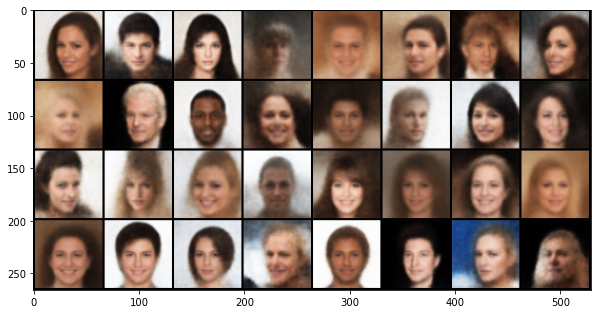

In [45]:
_ = show_recon("./exps/exp6")

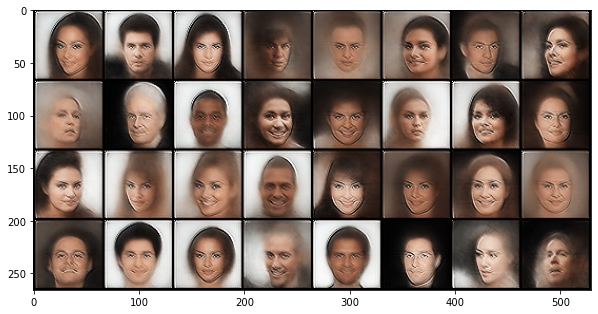

In [46]:
_ = show_recon("./exps/exp13")

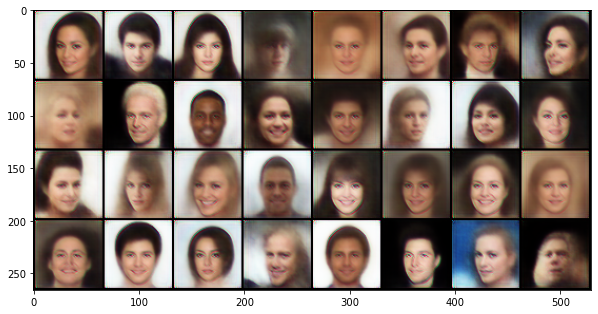

In [47]:
_ = show_recon("./exps/exp14")

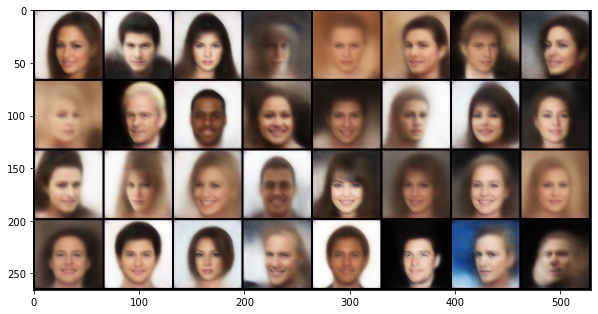

In [50]:
_ = show_recon("./exps/exp15")

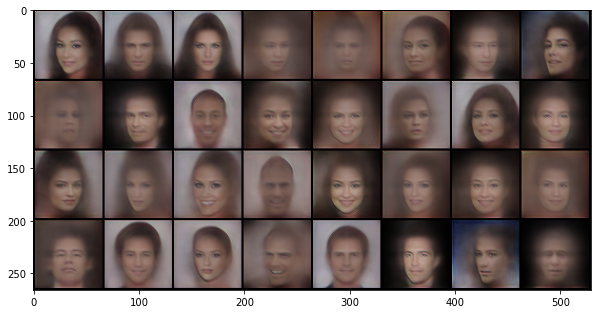

In [12]:
_ = show_recon("./exps/exp17")

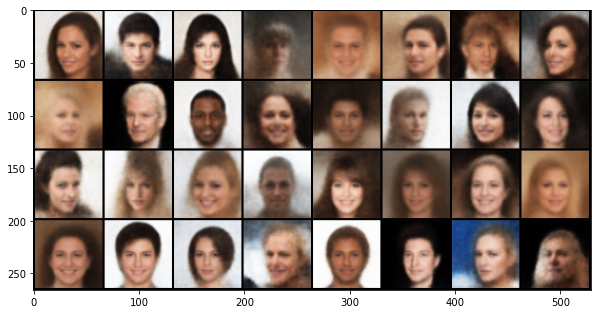

In [51]:
_ = show_recon("./exps/exp6")